In [76]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
from matplotlib import gridspec
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)


In [93]:
#Load model
model = pb.lithium_ion.DFN()

# create geometry
geometry = model.default_geometry

#Load parameter set
param = pb.ParameterValues("OKane2022")

In [88]:
def graphite_diffusivity_Dualfoil1998(sto, T):
    """
    Graphite diffusivity as a function of stoichiometry [1, 2, 3].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stoichiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature, [K]

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity [m2.s-1]
    """
    D_ref = 3.9 * 10 ** (-14)
    E_D_s = 5000
    T_ref = 298.15
    arrhenius = np.exp(E_D_s / pb.constants.R * (1 / T_ref - 1 / T))
    return D_ref * arrhenius


def graphite_electrolyte_exchange_current_density_Dualfoil1998(
    c_e, c_s_surf, c_s_max, T
):
    """
    Exchange-current density for Butler-Volmer reactions between graphite and LiPF6 in
    EC:DMC.

    References
    ----------
    .. [2] John Newman, Dualfoil

    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref = (
        1 * 10 ** (-11) * pb.constants.F
    )  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 5000  # activation energy for Temperature Dependent Reaction Constant [J/mol]
    arrhenius = np.exp(E_r / pb.constants.R * (1 / 298.15 - 1 / T))

    return m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5


def graphite_entropy_Enertech_Ai2020_function(sto):
    """
    Lithium Cobalt Oxide (LiCO2) entropic change in open-circuit potential (OCP) at
    a temperature of 298.15K as a function of the stoichiometry. The fit is taken
    from Ref [1], which is only accurate
    for 0.43 < sto < 0.9936.

    References
    ----------
    .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
    Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
    Lithium-Ion Pouch Cells.
    Journal of The Electrochemical Society, 167(1), 013512. DOI: 10.1149/2.0122001JES

    Parameters
    ----------
    sto: double
       stoichiometry of material (li-fraction)

    Returns
    -------
    :class:`pybamm.Symbol`
        Entropic change [V.K-1]
    """

    du_dT = (
        0.001
        * (
            0.005269056
            + 3.299265709 * sto
            - 91.79325798 * sto**2
            + 1004.911008 * sto**3
            - 5812.278127 * sto**4
            + 19329.7549 * sto**5
            - 37147.8947 * sto**6
            + 38379.18127 * sto**7
            - 16515.05308 * sto**8
        )
        / (
            1
            - 48.09287227 * sto
            + 1017.234804 * sto**2
            - 10481.80419 * sto**3
            + 59431.3 * sto**4
            - 195881.6488 * sto**5
            + 374577.3152 * sto**6
            - 385821.1607 * sto**7
            + 165705.8597 * sto**8
        )
    )

    return du_dT


def graphite_volume_change_Ai2020(sto):
    """
    Graphite particle volume change as a function of stoichiometry [1, 2].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stoichiometry, dimensionless
        should be R-averaged particle concentration
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]

    Returns
    -------
    t_change:class:`pybamm.Symbol`
        volume change, dimensionless, normalised by particle volume
    """
    p1 = 145.907
    p2 = -681.229
    p3 = 1334.442
    p4 = -1415.710
    p5 = 873.906
    p6 = -312.528
    p7 = 60.641
    p8 = -5.706
    p9 = 0.386
    p10 = -4.966e-05
    t_change = (
        p1 * sto**9
        + p2 * sto**8
        + p3 * sto**7
        + p4 * sto**6
        + p5 * sto**5
        + p6 * sto**4
        + p7 * sto**3
        + p8 * sto**2
        + p9 * sto
        + p10
    )
    return t_change


def graphite_cracking_rate_Ai2020(T_dim):
    """
    graphite particle cracking rate as a function of temperature [1, 2].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Deshpande, R., Verbrugge, M., Cheng, Y. T., Wang, J., & Liu, P. (2012).
     Battery cycle life prediction with coupled chemical degradation and fatigue
     mechanics. Journal of the Electrochemical Society, 159(10), A1730.

    Parameters
    ----------
    T_dim: :class:`pybamm.Symbol`
        temperature, [K]

    Returns
    -------
    k_cr: :class:`pybamm.Symbol`
        cracking rate, [m/(Pa.m0.5)^m_cr]
        where m_cr is another Paris' law constant
    """
    k_cr = 3.9e-20
    T_ref = 298.15
    Eac_cr = pb.Parameter(
        "Negative electrode activation energy for cracking rate [J.mol-1]"
    )
    arrhenius = np.exp(Eac_cr / pb.constants.R * (1 / T_dim - 1 / T_ref))
    return k_cr * arrhenius

graphite_ocp_Enertech_Ai2020_data = pb.parameters.process_1D_data(
    "graphite_ocp_Enertech_Ai2020.csv", path=r"C:\Users\frw21\OneDrive - Imperial College London\Misc\Desktop\ESE_UROP_2025\Project_Files\Model_testing"
)

def graphite_ocp_Enertech_Ai2020(sto):
    name, (x, y) = graphite_ocp_Enertech_Ai2020_data
    return pb.Interpolant(x, y, sto, name=name, interpolator="cubic")


In [89]:
param.update({# negative electrode from Ai2020
        "Negative electrode conductivity [S.m-1]": 100.0,
        #"Maximum concentration in negative electrode [mol.m-3]": 28700.0,
        "Negative particle diffusivity [m2.s-1]": graphite_diffusivity_Dualfoil1998,
        "Negative electrode OCP [V]": graphite_ocp_Enertech_Ai2020,
        "Negative electrode porosity": 0.33,
        "Negative electrode active material volume fraction": 0.61,
        "Negative particle radius [m]": 5e-06,
        "Negative electrode Bruggeman coefficient (electrolyte)": 2.914,
        "Negative electrode Bruggeman coefficient (electrode)": 0.0,
        "Negative electrode charge transfer coefficient": 0.5,
        "Negative electrode double-layer capacity [F.m-2]": 0.2,
        "Negative electrode exchange-current density [A.m-2]"
        "": graphite_electrolyte_exchange_current_density_Dualfoil1998,
        "Negative electrode density [kg.m-3]": 2470.0,
        "Negative electrode specific heat capacity [J.kg-1.K-1]": 1080.2,
        "Negative electrode thermal conductivity [W.m-1.K-1]": 1.04,
        "Negative electrode OCP entropic change [V.K-1]"
        "": graphite_entropy_Enertech_Ai2020_function,
        "Negative electrode Poisson's ratio": 0.3,
        "Negative electrode Young's modulus [Pa]": 15000000000.0,
        "Negative electrode reference concentration for free of deformation [mol.m-3]"
        "": 0.0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-06,
        "Negative electrode volume change": graphite_volume_change_Ai2020,
        "Negative electrode initial crack length [m]": 2e-08,
        "Negative electrode initial crack width [m]": 1.5e-08,
        "Negative electrode number of cracks per unit area [m-2]": 3180000000000000.0,
        "Negative electrode Paris' law constant b": 1.12,
        "Negative electrode Paris' law constant m": 2.2,
        "Negative electrode cracking rate": graphite_cracking_rate_Ai2020,
        #"Negative electrode activation energy for cracking rate [J.mol-1]": 0.0,
        "Negative electrode LAM constant proportional term [s-1]": 0.0,
        "Negative electrode LAM constant exponential term": 2.0,
        "Negative electrode critical stress [Pa]": 60000000.0,})

In [98]:
#GITT Experiment text
V_max = 4.2;        V_min = 2.5
'''exp_topup_text = [ (
    f"Charge at 0.5C until {V_max-0.2}V", # start from discharge as it is easier for unbalanced cells
    f"Charge at 0.3C until {V_max}V",
    ) ] '''
    
exp_GITT_text = [ (
    "Discharge at C/20 for 1 hour", "Rest for 1 hour"
    ) ]

experiment = pb.Experiment( [("Charge at 0.5C until SOC=100", "Discharge at C/5 until SOC=0")] ) 

var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 80,  # negative particle
    "r_p": 20,  # positive particle
}

pb.set_logging_level("NOTICE")

ValueError: could not convert string to float: ''

In [95]:
# run pybamm model
sim = pb.Simulation(
    model=model, 
    experiment = experiment,
    parameter_values=param,
    solver=model.default_solver,
    var_pts=var_pts, )
sol = sim.solve(calc_esoh=False,)



2025-07-11 15:48:56.762 - [NOTICE] logger.func(7): Cycle 1/1 (14.100 us elapsed) --------------------
2025-07-11 15:48:56.763 - [NOTICE] logger.func(7): Cycle 1/1, step 1/2: Charge at 0.5C until 4.2V
2025-07-11 15:48:56.919 - [NOTICE] logger.func(7): Cycle 1/1, step 2/2: Discharge at C/5 until 2.5V
2025-07-11 15:48:57.178 - [NOTICE] logger.func(7): Finish experiment simulation, took 415.568 ms


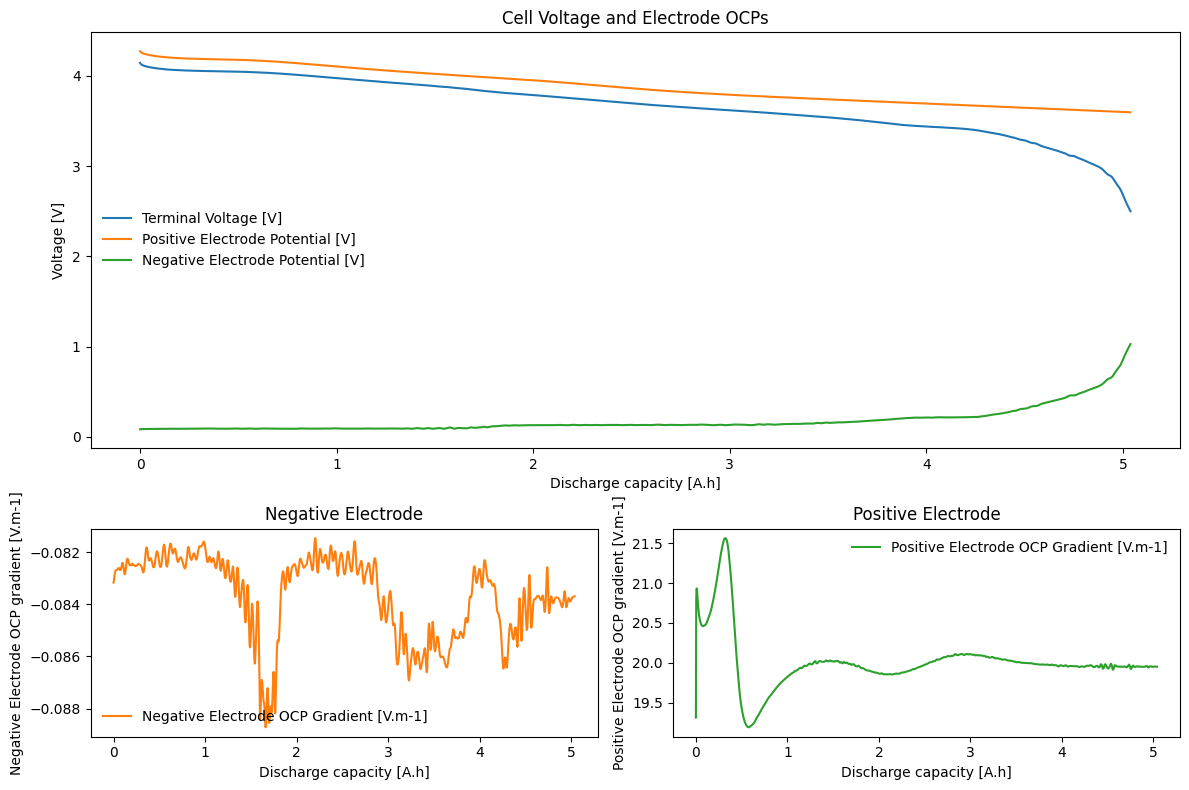

In [96]:
def Plot_Comp_DMA_Overall_GITT(sol, Save_Fig=False, fig_name=None):
    t = sol["Time [s]"].entries
    x = sol["x [m]"].entries[:, 0]
    OCP_PE = sol["Positive electrode open-circuit potential [V]"]
    OCP_NE = sol["Negative electrode open-circuit potential [V]"]
    OCP = sol["Terminal voltage [V]"]    
    OCP_NE_GRAD = sol["Gradient of negative electrode potential [V.m-1]"]
    OCP_PE_GRAD = sol["Gradient of positive electrode potential [V.m-1]"]
    C = sol['Discharge capacity [A.h]']
    
    
    # Create a gridspec for custom subplot layout: 1 row on top, 2 beloW
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

    # Top subplot spans both columns
    ax1 = fig.add_subplot(gs[0, :])
    # Bottom left and right subplots
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    # First subplot: Voltage and OCPs
    ax1.plot(C(t), OCP(t))
    ax1.set_ylabel("Voltage [V]")

    ax1.plot(C(t), OCP_PE(t=t)[0])
    ax1.plot(C(t), OCP_NE(t=t)[0])

    ax1.legend(
        [
            "Terminal Voltage [V]",
            "Positive Electrode Potential [V]",
            "Negative Electrode Potential [V]"
        ], loc='best', frameon=False
    )
    ax1.set_title("Cell Voltage and Electrode OCPs")
    ax1.set_xlabel('Discharge capacity [A.h]')

    # Second subplot: Negative Electrode OCP Gradient
    ax3.plot(C(t), OCP_NE_GRAD(t=t)[0], label="Negative Electrode OCP Gradient [V.m-1]", color='C1')
    ax3.set_ylabel("Negative Electrode OCP gradient [V.m-1]")
    ax3.set_xlabel('Discharge capacity [A.h]')
    ax3.legend(loc='best', frameon=False)
    ax3.set_title("Negative Electrode")

    # Third subplot: Positive Electrode OCP Gradient
    ax4.plot(C(t), OCP_PE_GRAD(t=t)[0], label="Positive Electrode OCP Gradient [V.m-1]", color='C2')
    ax4.set_ylabel("Positive Electrode OCP gradient [V.m-1]")
    ax4.set_xlabel('Discharge capacity [A.h]')
    ax4.legend(loc='best', frameon=False)
    ax4.set_title("Positive Electrode")

    plt.tight_layout()

    if Save_Fig:
        Save_path = os.path.join(
            r'C:\Users\frw21\Desktop\ESE_UROP_2025\Project_Files\Model_testing\Figures\\', fig_name
        )
        plt.savefig(Save_path, dpi=600)
        print(f"Figure saved to {Save_path}")\
        
    plt.show()

Plot_Comp_DMA_Overall_GITT(sol=sol, Save_Fig=False, fig_name="DMA_Overall_Plots_Cycling.png")

In [74]:
model.variables.search("concentration")

Results for 'concentration': ['Negative particle concentration [mol.m-3]', 'X-averaged negative particle concentration [mol.m-3]', 'R-averaged negative particle concentration [mol.m-3]', 'Average negative particle concentration [mol.m-3]', 'Negative particle surface concentration [mol.m-3]', 'X-averaged negative particle surface concentration [mol.m-3]', 'Minimum negative particle concentration [mol.m-3]', 'Maximum negative particle concentration [mol.m-3]', 'Minimum negative particle Minimum negative particle surface concentration [mol.m-3]', 'Maximum negative particle surface concentration [mol.m-3]', 'Negative particle concentration', 'X-averaged negative particle concentration', 'R-averaged negative particle concentration', 'Average negative particle concentration', 'Negative particle surface concentration', 'X-averaged negative particle surface concentration', 'Minimum negative particle concentration', 'Maximum negative particle concentration', 'Minimum negative particle surface c

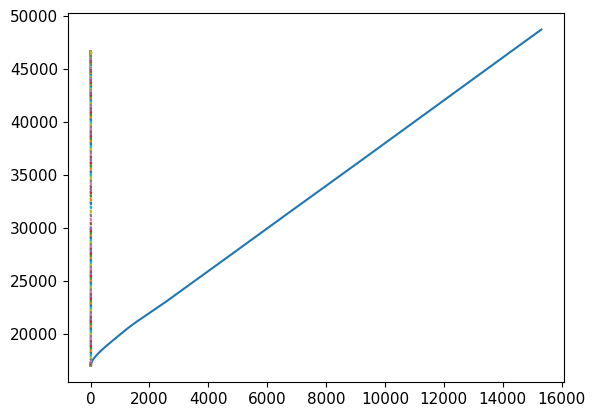

In [73]:
c_p_max = sol['Maximum positive particle concentration [mol.m-3]']
c_p = sol['Positive particle concentration [mol.m-3]']
t = sol["Time [s]"].entries
x = sol["x [m]"].entries[:, 0]

plt.plot(t, c_p_max(t=t), label='Maximum positive particle concentration [mol.m-3]')
plt.plot(c_p(x=x)[1], label='Maximum positive particle concentration [mol.m-3]')

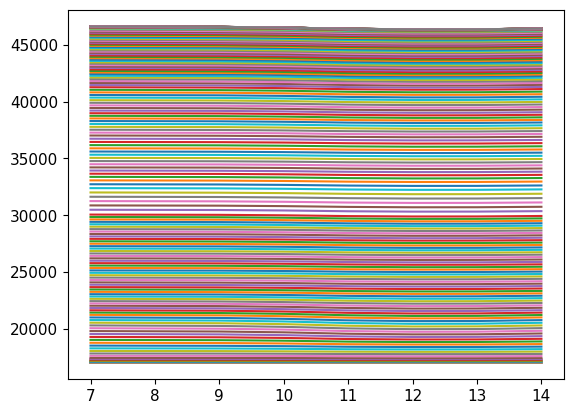

In [75]:
plt.plot(c_p(x=x)[1], label='Maximum positive particle concentration [mol.m-3]')